In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
# All complete griz exposures from /data3/garyb/tno/y6/zone134.
exps = np.array([
    348819, 355303, 361577, 361580, 361582, 362365, 362366, 364209,
    364210, 364213, 364215, 367482, 367483, 367484, 367488, 369801,
    369802, 369803, 369804, 370199, 370200, 370204, 370600, 370601,
    370602, 370609, 371367, 371368, 371369, 372006, 372064, 372437,
    372522, 373245, 374797, 474260, 474261, 474262, 474263, 474264,
    474265, 476846, 484481, 484482, 484483, 484490, 484491, 484499,
    573396, 573398, 576861, 576862, 576863, 576864, 576865, 576866,
    579815, 579816, 586534, 592152, 674340, 675645, 676791, 676792,
    676799, 676800, 676801, 680497, 681166, 686427, 686457, 686459,
    689611, 689612, 689613, 691478, 696547, 696552, 784503, 788112,
    788113, 788116, 788117, 791184, 791186, 791215, 791229, 791593,
    791640])
bandDict = {
    'g': [
        361580, 367484, 369801, 369803, 370204,
        370601, 371369, 372064, 372522, 474262,
        474265, 484483, 576863, 576866, 579816,
        676792, 676800, 696547, 791229, 791593,
        791640],
    'r': [
        361577, 362366, 367482, 367488, 369802,
        370200, 370600, 370602, 371368, 474261,
        474264, 484481, 576861, 576865, 579815,
        676791, 676799, 676801, 681166, 689612,
        791184, 791186, 791215],
    'i': [
        361582, 362365, 364210, 364213, 367483,
        369804, 370199, 370609, 371367, 474260,
        474263, 484499, 576862, 576864, 586534,
        680497, 686427, 686457, 689611, 696552,
        788113, 788116, 788117],
    'z': [
        348819, 355303, 364209, 364215, 372006,
        372437, 373245, 374797, 476846, 484482,
        484490, 484491, 573396, 573398, 592152,
        674340, 675645, 686459, 689613, 691478,
        784503, 788112]}


# These are the exposures, from /home/fortino/DESworkspace/data/eris.fits, that the TNO Eris appears in.
# There are 9 more exposures in /home/fortino/DESworkspace/data/eris.fits that don't seem to be present
# in any zone in /data3/garyb/tno/y6/zone??? as of July 28, 2020.
erisExps = np.array([
    233221, 234928, 240777, 241125, 246881, 264536, 364725, 364726,
    364727, 370653, 370685, 374544, 374550, 382258, 384049, 388143,
    398226, 398231, 478983, 486775, 488823, 488824, 490665, 503010,
    503041, 507393, 507394, 567918, 568777, 591792, 591793, 596103,
    596104, 596105, 596512, 597221, 597555, 600469, 600470, 683902,
    692049, 692050, 696363, 697638, 697639, 706447, 776431, 782097,
    782098, 782099])
erisBandDict = {
    'Y': [
        234928, 264536, 374544, 384049,
        478983, 591793, 600470, 706447],
    'g': [
        233221, 240777, 241125, 246881,
        364726, 568777, 596105, 597555,
        696363, 697639, 782099],
    'r': [
        364725, 370653, 370685, 382258,
        490665, 567918, 596103, 596512,
        692049, 697638, 782098],
    'i': [
        364727, 388143, 488824, 503041,
        507393, 596104, 597221, 692050,
        782097],
      'z': [
        374550, 398226, 398231, 486775,
        488823, 503010, 507394, 591792,
        600469, 683902, 776431]}

# My tileRef file, /home/fortino/DESworkspace/data/expnum_tile.fits.gz, seems to think
# These two exposures are inside these two tile files. What's up with that? tileRef is probably
# right, but since the y6 files seem to be actively being worked on, I would guess that it's because
# I have incomplete data.
# /data3/garyb/tno/y6/zone019/DES0139-0124_final.fits is supposed to include exposure 364726, but doesn't.
# /data3/garyb/tno/y6/zone020/DES0145-0041_final.fits is supposed to include exposure 782099, but doesn't.

In [3]:
# Given an exposure, search for all of its constituent tiles within /data3/garyb/tno/y6/zone???.
def findTiles(expNum, confirmTiles=False):
    # Get a list of all tiles in /data3/garyb/tno/y6/zone???.
    zones = "/data3/garyb/tno/y6/zone[0,1,2][0,1,2,3,4,5,6,7,8,9][0,1,2,3,4,5,6,7,8,9]"
    tiles = "DES????[+,-]????_final.fits"
    allTiles = sorted(glob.glob(os.path.join(zones, tiles)))

    # Open the fits file that relates exposure number to tile name and get all of the tile names for the chosen exposure.
    tileRef = "/home/fortino/DESworkspace/data/expnum_tile.fits.gz"
    tileRef = tb.Table.read(tileRef)
    tilenames = tileRef[tileRef["EXPNUM"] == expNum]["TILENAME"].data.astype(str)

    # Initialize the list that will store all of the file names (inlcuding path) for each constituent tile of the exposure.
    tilefiles = []

    # Loop through all of the tile files and see which ones make up the chosen exposure.
    for tile in allTiles:

        # Remove the "_final.fits" from the file name.
        tilename = os.path.basename(tile)[:-11]

        # Check if this tile name is one of the ones that make up the chosen exposure.
        if tilename in tilenames:
            tilefiles.append(tile)

    if len(tilefiles) == 0:
        print(f"There are no known tiles for exposure {expNum}.")
        return
    else:
        if confirmTiles:
            confirmed_tilefiles = []
            for tilefile in tilefiles:
                tile = tb.Table.read(tilefile)
                confirm = len(tile[tile["EXPNUM"] == expNum])
                if confirm != 0:
                    confirmed_tilefiles.append(tilefile)
                else:
                    print(f"{tilefile} is supposed to include exposure {expNum}, but doesn't.")

            if len(confirmed_tilefiles) == 0:
                print(f"All suggested tiles did not include exposure {expNum}. Perhaps tileRef file is wrong.")
                return
            else:
                return confirmed_tilefiles
        else:   
            return tilefiles
        
# Given an exposure, find what passband it is.
def getBand(expNum, confirmTiles=False):

    # First look through bandDict, containing all of the griz exposures from zone 134.
    # This provides very fast passband lookup times for frequently used exposures.
    for key, value in bandDict.items():
        if expNum in value:
            return key

    # Find all of the tiles that make up this exposures.
    tilefiles = findTiles(expNum, confirmTiles=confirmTiles)
    
    # Open any of the tiles and open it.
    tile = tb.Table.read(tilefiles[0])

    # Find which band the exposure is in by indexing the table.
    band = np.unique(tile[tile["EXPNUM"] == expNum]["BAND"])[0]

    return band

# Given a fits file with a column of exposures, find all exposures that have some amount of known tiles.
def get_erisExps(erisFits="/home/fortino/DESworkspace/data/eris.fits"):
    eris = tb.Table.read(erisFits)
    
    eris_exps = []
    for expNum in eris["EXPNUM"]:
        tiles = findTiles(expNum)
        if tiles is not None:
            eris_exps.append(expNum)
    
    return np.array(eris_exps).astype(int)

In [46]:
class parseOutfile(object):
    
    def __init__(self, OUTfile):
        root, ext = os.path.splitext(OUTfile)
        self.FITSfile = root + ".fits"
        
        with open(OUTfile, "r") as f:
            out = f.readlines()
            
        # Check for LinAlgErr.
        if "LinAlgError" in out[-1]:
            self.LinAlgErr = True
            self.LinAlgErr_params = out[-1]
            self.finished = False
            return
        else:
            self.LinAlgErr = False
            
        # Check for completion.
        if "Total Time" not in out[-6]:
            self.finished = False
            return
        else:
            self.finished = True
            
        fitCorr = False
        opt1 = False
        opt2 = False
        
        self.nfC = 0
        self.nOpt1 = 0
        self.nOpt2 = 0
        
        for line in out:
            
            if "RSS" in line:
                fitCorr = True
                
            elif "xi +" in line:
                fitCorr = False
                
                if opt1:
                    opt1 = False
                    opt2 = True
                else:
                    opt1 = True
                    
            elif "Time" in line:
                parseTime = lambda line, unit: float(line.split(":")[1][:7])*unit

                if "Total" in line:
                    self.totalTime = parseTime(line, u.hr)
                elif "Load" in line:
                    self.loadTime = parseTime(line, u.s)
                elif "Correlation Fitting" in line:
                    self.fitCorrTime = parseTime(line, u.min)
                elif "Correlating Fitting Jackknife" in line:
                    self.fitCorrJKTime = parseTime(line, u.min)
                elif "Optimization Time" in line:
                    self.optTime = parseTime(line, u.hr)
                elif "Optimization Jackknife" in line:
                    self.optJKTime = parseTime(line, u.min)

            else:
                if fitCorr:
                    self.nfC += 1
                if opt1:
                    self.nOpt1 += 1
                if opt2:
                    self.nOpt2 += 1
                    
        self.nGP = self.nOpt1 + self.nOpt2
        self.avgGPTime = (self.optTime / self.nGP).to(u.min)
        
def get_expAvg_avgOptTime(OUTfiles, returnPercs=False, info=False):
    avgGPTimes = np.array([])
    for OUTfile in OUTfiles:
        parseOut = parseOutfile(OUTfile)
        if not parseOut.finished:
            if parseOut.LinAlgErr:
                if info:
                    print(parseOut.LinAlgErr_params)
            continue
        else:
            avgGPTimes = np.append(avgGPTimes, parseOut.avgGPTime.value)

    if returnPercs:
        return np.percentile(avgGPTimes, (25, 50, 75))*(parseOut.avgGPTime.unit)
    else:
        return np.mean(avgGPTimes)*(parseOut.avgGPTime.unit)
    
def get_LinAlgErrors(OUTfiles):
    for OUTfile in OUTfiles:
        parseOut = parseOutfile(OUTfile)
        if parseOut.LinAlgErr:
            print(parseOut.FITSfile)
            print(parseOut.LinAlgErr_params)
            
def get_expAvg_optTime(OUTfiles, returnPercs=False, returnList=False, info=False):
    optTimes = np.array([])
    for OUTfile in OUTfiles:
        parseOut = parseOutfile(OUTfile)
        if not parseOut.finished:
            if parseOut.LinAlgErr:
                if info:
                    print(parseOut.LinAlgErr_params)
            continue
        else:
            optTimes = np.append(optTimes, parseOut.optTime.value)
            
    if returnPercs:
        return np.percentile(optTimes, (25, 50, 75))*(parseOut.optTime.unit)
    elif returnList:
        return optTimes*(parseOut.optTime.unit)
    else:
        return np.mean(optTimes)*(parseOut.optTime.unit)

2.399784084855252 min
3.0714285714285716 h
/home/fortino/GPRSolutions/L_BFGS_B_max/GPR.367488.rRC.out 80 15
/home/fortino/GPRSolutions/L_BFGS_B_max/GPR.370204.gRC.out 100 60
/home/fortino/GPRSolutions/L_BFGS_B_max/GPR.484490.zRC.out 108 21


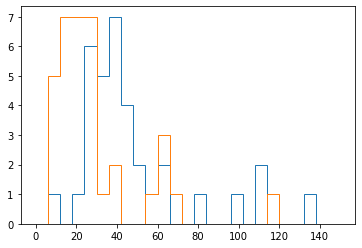

In [76]:
OUTfile = "/home/fortino/GPRSolutions/L_BFGS_B_max/GPR.372437.zRC.out"
pO = parseOutfile(OUTfile)
pO.nOpt1, pO.nOpt2

(112, 12)

/home/fortino/GPRSolutions/L_BFGS_B_max/GPR.372437.zRC.out
Can reduce tolerance or 